![image.png](attachment:image.png)

# Tarefa II

Ainda sobre a base da NFP vista na tarefa passada:

|Campo|Descrição|
|:-|:-|
|CNPJ emit.| CNPJ do emitente da nota|
|Emitente| Nome fantasia do emitente da nota|
|No.| Número da nota fiscal|
|Data Emissão| Data de emissão da nota fiscal|
|Valor NF| Valor da nota fiscal|
|Data Registro| Data de registro no sistema da NFP|
|Créditos| Valor dos créditos (doação)|
|Situação do Crédito| Se o crédito já foi pago, está sendo processado etc.|
|Ano| Ano da emissão da nota|
|Semestre| Semestre da emissão da nota|
|Retorno| Valor do crédito dividido pelo valor da nota|
|flag_credito| Indicadora se a nota possui crédito positivo|
|categoria| Categorização da nota |

**OBJETIVO:** Algumas notas não dão retorno, o que pode ocorrer por diversos motivos, um deles seria a ocorrência de produtos não incentivados como cigarros e bebidas alcólicas. O nosso objetivo é tentar prever que tipo de nota tem maior ou menor propensão a fornecer créditos.

**Observação**: Esta é uma base real, havendo características de acordo. Pode haver uma variabilidade difícil de explicar, em parte por causa de uma freqüência de notas inconstante no tempo (por diversos motivos), em parte por haverem informações importantes, protegidas pela LGPD, não constantes na base, que pode interferir no crédito gerado, o que vai ocasionar uma variabilidade difícil de se explicar. *Welcome to the jungle*, A vida real é assim :)

In [324]:
!pip install woe_iv_bin

In [325]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from woe_iv_bin import categorical_woe

In [326]:
df = pd.read_pickle('base_nfp.pkl')

## Criando variáveis

**Variáveis temporais**: É possível que haja alguma regra de liberação de créditos de acordo com o dia do mês, o dia da semana, fim de semana (sim ou não), ou até alterações temporais da regra. Vamos criar as seguintes variáveis para testar estas hipóteses:

- Dia da semana
- Dummy para fim de semana
- Dia do mês
- Mês (já na base)
- Trimestre
- Ano (já na base)

**Valor da nota**: Vamos criar também algumas variáveis para resumir o valor da nota, e posteriormente criar uma intuição sobre categorizações de variáveis contínuas.

- Crie categorizações da variável ```Valor NF```, por quantís, em 5, 10, 20 e 50 categorias.

In [327]:
# Convertendo 'Data Emissão' para datetime
df['Data Emissão'] = pd.to_datetime(df['Data Emissão'])

# Criando as variáveis temporais
df['Dia da Semana'] = df['Data Emissão'].dt.dayofweek
df['Fim de Semana'] = df['Dia da Semana'].isin([5, 6]).astype(int)
df['Dia do Mês'] = df['Data Emissão'].dt.day
df['Trimestre'] = df['Data Emissão'].dt.quarter
df['Mês'] = df['Data Emissão'].dt.month
df['Ano'] = df['Data Emissão'].dt.year


# Categorizando 'Valor NF' por quantis
df['Valor NF Cat 5'] = pd.qcut(df['Valor NF'], q=5, labels=False)
df['Valor NF Cat 10'] = pd.qcut(df['Valor NF'], q=10, labels=False)
df['Valor NF Cat 20'] = pd.qcut(df['Valor NF'], q=20, labels=False)
df['Valor NF Cat 50'] = pd.qcut(df['Valor NF'], q=50, labels=False)

## Calcule o IV de todas essas variáveis

Sugestão: Construa um metadados e tente utilizar uma função como a que foi utilizada durante a aula. Você vai conseguir fazer esse cálculo para as variáveis uma a uma, mas em casos reais em que vamos mais além na criação de variáveis, podemos ter centenas, ou até milhares de variáveis, esses cálculos *precisam* ser automáticos nesses casos.

In [328]:
def calculate_iv(df, feature, target):
    # Calculando a proporção de eventos positivos e negativos
    proporcao_positivos = df.groupby(feature)[target].mean()
    proporcao_negativos = 1 - proporcao_positivos

    # Calculando o WOE para cada categoria
    woe = np.log(proporcao_positivos / proporcao_negativos)

    # Calculando a diferença entre a proporção de eventos positivos e negativos
    diff = proporcao_positivos - proporcao_negativos

    # Calculando o IV
    iv = np.sum(diff * woe)

    return iv

df['Retorno Positivo'] = df['Retorno'] > 0


In [329]:
# Lista de variáveis para calcular o IV
features = ['Dia da Semana', 'Fim de Semana', 'Dia do Mês', 'Trimestre', 'Mês', 'Ano', 'Valor NF Cat 5', 'Valor NF Cat 10', 'Valor NF Cat 20', 'Valor NF Cat 50']

# Calculando o IV para cada variável
iv_values = {feature: calculate_iv(df, feature, 'Retorno Positivo') for feature in features}

In [330]:
# Exibindo os valores de IV
lista_iv = {}
for feature, iv in iv_values.items():
    print(f'IV PARA {feature}: {iv}')
    lista_iv[feature] = iv

IV PARA Dia da Semana: 0.1567735855710056
IV PARA Fim de Semana: 0.0313821864892441
IV PARA Dia do Mês: 1.1272530953547744
IV PARA Trimestre: 0.0978850029466153
IV PARA Mês: 0.3701840724513359
IV PARA Ano: 0.1733452329463221
IV PARA Valor NF Cat 5: 0.2378813317593259
IV PARA Valor NF Cat 10: 0.7252380063585031
IV PARA Valor NF Cat 20: 1.637025508395335
IV PARA Valor NF Cat 50: 4.7874806908939


In [331]:
lista_ordenada = sorted(lista_iv.items(), key=lambda item: item[1], reverse=True)
lista_ordenada[:5]

[('Valor NF Cat 50', 4.7874806908939),
 ('Valor NF Cat 20', 1.637025508395335),
 ('Dia do Mês', 1.1272530953547744),
 ('Valor NF Cat 10', 0.7252380063585031),
 ('Mês', 0.3701840724513359)]

## Conclua

- Quais variáveis parecem apresentar maior poder de discriminação segundo o IV?
- Quando categorizamos variáveis contínuas parece haver alguma relação entre o número de categorias e o IV?

> As 5 variáveis que parecem apresentar maior poder de discriminação segundo o IV são:<br>
**Valor NF Cat 50, 4.7874806908939<br>
Valor NF Cat 20, 1.637025508395335<br>
Dia do Mês, 1.1272530953547744<br>
Valor NF Cat 10, 0.7252380063585031<br>
Mês, 0.3701840724513359**<br>

## Descritiva simples no tempo

Para compor a análise que virá a seguir, faça uma análise descritiva básica no tempo - utilize trimestre como agregação (ou uma média móvel por trimestre, como preferir) e avalie graficamente:

- A quantidade de notas registradas na base por período
- A quantidade de notas por categoria e por período
- A proporção de notas com crédito por categoria por período

In [332]:
# Setando o estilo dos gráficos
plt.style.use('seaborn-dark-palette')

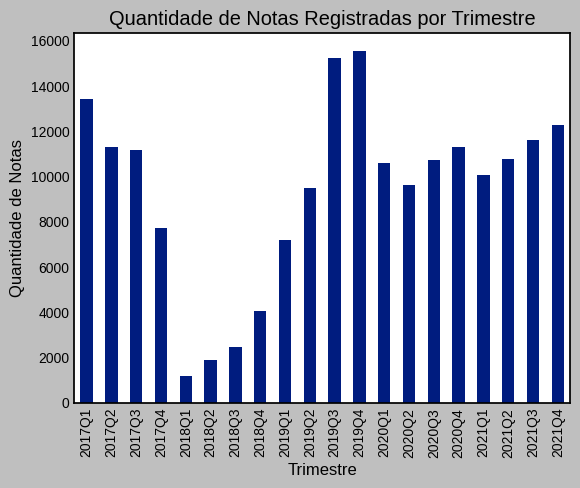

In [333]:
# Convertendo 'Data Emissão' para datetime e criando a coluna 'Trimestre'
df['Data Emissão'] = pd.to_datetime(df['Data Emissão'])
df['Trimestre'] = df['Data Emissão'].dt.to_period('Q')

# Calculando a quantidade de notas registradas na base por período
notas_por_periodo = df.groupby('Trimestre').size()

# Plotando a quantidade de notas registradas na base por período
notas_por_periodo.plot(kind='bar')
plt.ylabel('Quantidade de Notas')
plt.xlabel('Trimestre')
plt.title('Quantidade de Notas Registradas por Trimestre')
plt.show()

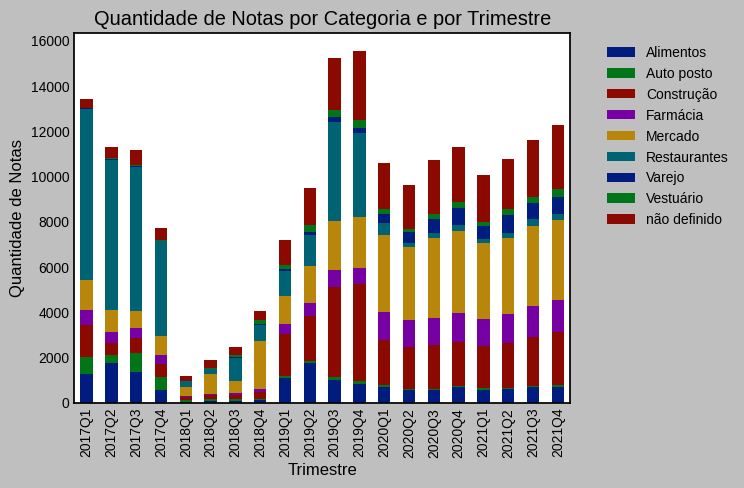

In [334]:
# Calculando a quantidade de notas por categoria e por trimestre
notas_por_categoria_periodo = df.groupby(['Trimestre', 'categoria']).size().unstack()

# Plotando a quantidade de notas por categoria e por trimestre
ax = notas_por_categoria_periodo.plot(kind='bar', stacked=True)
plt.ylabel('Quantidade de Notas')
plt.xlabel('Trimestre')
plt.title('Quantidade de Notas por Categoria e por Trimestre')
ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

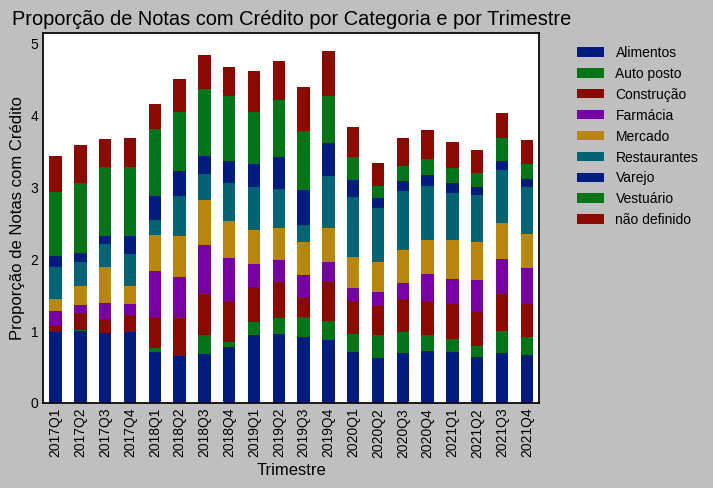

In [335]:
# Calculando a proporção de notas com crédito por categoria por trimestre
df['Crédito Positivo'] = df['Créditos'] > 0
proporcao_credito_por_categoria_periodo = df.groupby(['Trimestre', 'categoria'])['Crédito Positivo'].mean().unstack()

# Plotando a proporção de notas com crédito por categoria por trimestre
ax = proporcao_credito_por_categoria_periodo.plot(kind='bar', stacked=True)
plt.ylabel('Proporção de Notas com Crédito')
plt.title('Proporção de Notas com Crédito por Categoria e por Trimestre')
plt.xlabel('Trimestre')
ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

## Avalie o WOE e o IV no tempo

Avalie o WOE e o IV no tempo da variável ```categoria```.

In [336]:
# Ajustando o dataframe para mostrar apenas os dados dos anos depois de 2020
df= df[df['Ano']>=2020]

In [337]:
df_ = df.groupby(['Trimestre', 'categoria', 'flag_credito']).size().unstack(fill_value=0)
df_['soma'] = df_.sum(axis=1)
df_['tx_evento'] = df_[1]/df_[0]
df_['pct_evento'] = df_[1]/df_[1].groupby(level=0).sum()
df_['pct_nao_evento'] = df_[0]/df_[0].groupby(level=0).sum()
df_['WOE'] = np.log(df_.pct_evento/df_.pct_nao_evento)
df_.head()

flag_credito             0     1  soma  tx_evento  pct_evento  pct_nao_evento  \
Trimestre categoria                                                             
2020Q1    Alimentos    202   499   701   2.470297    0.109190        0.033588   
          Auto posto    66    22    88   0.333333    0.004814        0.010974   
          Construção  1089   910  1999   0.835629    0.199125        0.181077   
          Farmácia     992   226  1218   0.227823    0.049453        0.164948   
          Mercado     1939  1465  3404   0.755544    0.320569        0.322414   

flag_credito               WOE  
Trimestre categoria             
2020Q1    Alimentos   1.178915  
          Auto posto -0.824035  
          Construção  0.095006  
          Farmácia   -1.204611  
          Mercado    -0.005740

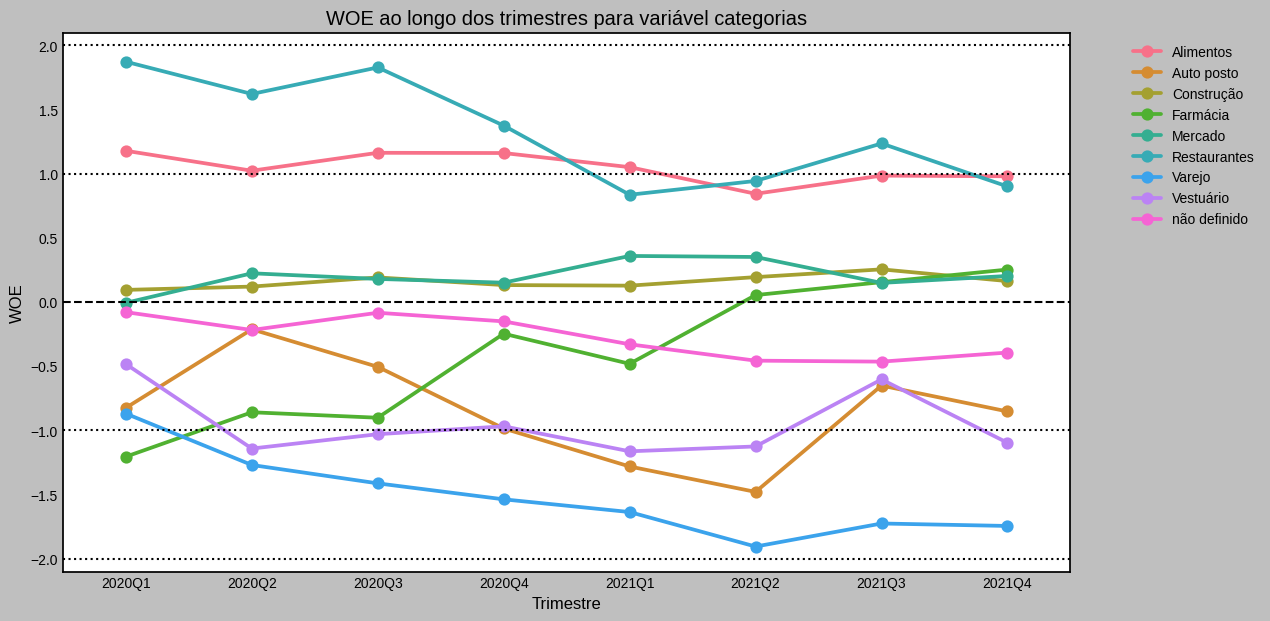

In [347]:
fig, ax = plt.subplots(figsize=(13,7))

# Comando principal do gráfico
sns.pointplot(data=df_.reset_index(), y = 'WOE', x = 'Trimestre', hue='categoria', ax=ax);

#limites do gráfico - mostrando 1 e -1 para ter referência
ymax = max(2.1, max(df_.WOE))
ymin = min(-2.1, min(df_.WOE))
ax.set_ylim([ymin, ymax])

# Linhas de referência
ax.axhline(2, linestyle=':' )
ax.axhline(1, linestyle=':' )
ax.axhline(0, linestyle='--')
ax.axhline(-1, linestyle=':')
ax.axhline(-2, linestyle=':')

ax.set_title(f'WOE ao longo dos trimestres para variável categorias')

ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

In [353]:
df_['IV'] = (df_.pct_evento - df_.pct_nao_evento)*df_.WOE

Text(0.5, 1.0, 'IV ao longo dos trimestres para variável categorias')

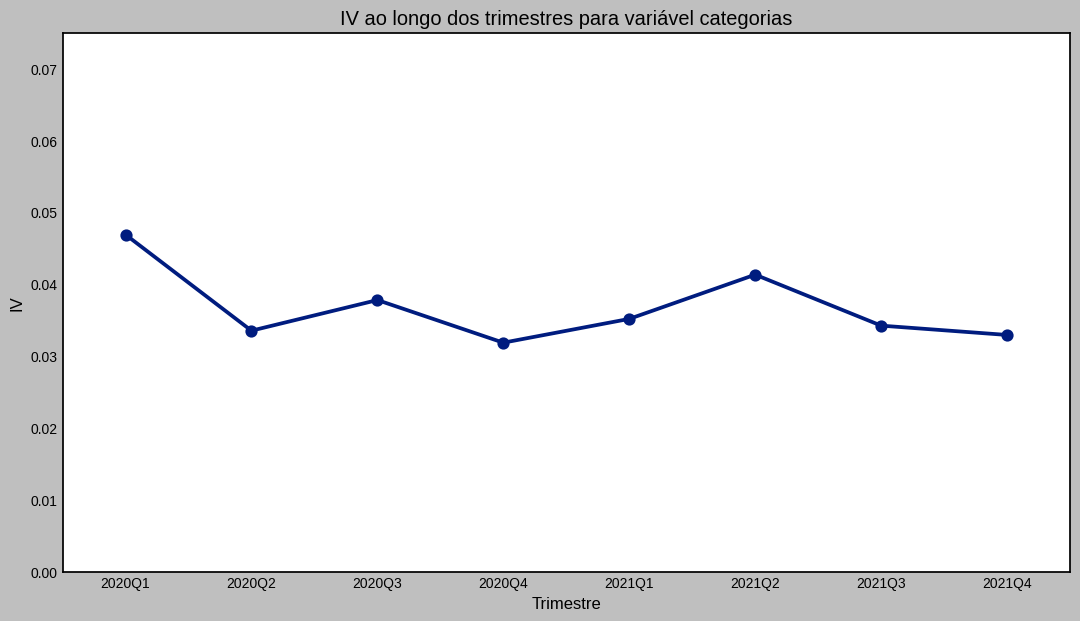

In [367]:
fig, ax = plt.subplots(figsize=(13,7))

# Comando principal do gráfico
sns.pointplot(data=df_.reset_index(), y = 'IV', x = 'Trimestre', ax=ax, ci=None);
ax.set_ylim([0, 0.075])

ax.set_title(f'IV ao longo dos trimestres para variável categorias')

## Conclua

- Quais categorias parece ter maior proporção de notas com retornos maiores que zero?
- Essas diferenças são estáveis no tempo?

Dicas:<br>
- Considere que a quantidade de notas vem aumentando
- Considere que há períodos bem atípicos no histórico
- Considere que a partir de janeiro de 2020 o público é mais parecido com o público atual (2022), seja por pandemia, seja por crescimento do público, e considere os dados dessa data em diante na sua conclusão.

> As categorias de varejo e alimentos são as que possuem maior proporção de notas com retornos maiores que zero. No gráfico de IV podemos verificar um poder preditivo baixo ao longo do tempo.